<h2> Applied Data Science Capstone Project</h2>
<p>By Andres Lopez</p>
<p>May 2020</p>
<p>To better understand the steps below, please read the companion report.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import requests
import folium
from sklearn.cluster import KMeans

In [2]:
#Foursquare credentials
#To keep the credentials confidential, the Client ID and the Secret
#were placed in a csv file and imorted to a pandas dataframe
file = "Credentials.csv"
df_credentials = pd.read_csv(file)
CLIENT_ID = df_credentials.loc[0, 'Value']
CLIENT_SECRET = df_credentials.loc[1, 'Value'] 
VERSION = '20200430'
LIMIT = 200

#Foursquare Venue Category IDs
VIE = '4bf58dd8d48988d14a941735'
THA = '4bf58dd8d48988d149941735'
KOR = '4bf58dd8d48988d113941735'
CHN = '4bf58dd8d48988d145941735'
JPN = '4bf58dd8d48988d111941735'

<p><strong>Coordinates  and map of the ten areas in Houston selected for this study</strong></p>

In [3]:
file = "HoustonAreas.csv"
df_areas = pd.read_csv(file)
df_areas

,Area,Latitude,Longitude
0,Channelview,29.77606,-95.11465
1,Cinco Ranch,29.73884,-95.75800
2,Cypress,29.97169,-95.69379
3,Galleria,29.73591,-95.46418
4,Greenspoint,29.95063,-95.40279
5,Jersey Village,29.88773,-95.56300
6,Kingwood,30.05003,-95.18448
7,Pearland,29.56357,-95.28605
8,Sugarland,29.55413,-95.67578
9,The Woodlands,30.16582,-95.46126


In [4]:
hou_lat = 29.8511
hou_lng = -95.3698
map_houston = folium.Map(location=[hou_lat, hou_lng], zoom_start=10)
for area, lat, lng in zip(df_areas['Area'], 
        df_areas['Latitude'], df_areas['Longitude']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [lat, lng],
            radius=15,
            popup=label,
            color='#0d59a1',
            fill=True,
            fill_color='#0d59a1',
            opacity=1,
            parse_html=False).add_to(map_houston)
map_houston

<p><strong>Foursquare API calls and response processing</strong></p>

In [5]:
radius = 8000
asian_rest = pd.DataFrame(columns = ['Area', 'Area Lat', 'Area Lng', 'Restaurant Name', 'RestLat', 'RestLng', 'Category'])
for area, lat, lng in zip(df_areas['Area'], df_areas['Latitude'], df_areas['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={},{},{},{},{}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT, VIE, THA, KOR, CHN, JPN)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        for restaurants in results:
            new_row = [area, lat, lng,
                       restaurants['venue']['name'], 
                       restaurants['venue']['location']['lat'], 
                       restaurants['venue']['location']['lng'],  
                       restaurants['venue']['categories'][0]['name']]
            add = pd.Series(new_row, index = asian_rest.columns)
            asian_rest = asian_rest.append(add, ignore_index=True)
asian_rest.head()            

,Area,Area Lat,Area Lng,Restaurant Name,RestLat,RestLng,Category
0,Channelview,29.77606,-95.11465,Bamboo China Cafe,29.806960,-95.168218,Chinese Restaurant
1,Channelview,29.77606,-95.11465,Bibo's Cafe,29.824889,-95.167574,Vietnamese Restaurant
2,Channelview,29.77606,-95.11465,Panda Express,29.771835,-95.186176,Chinese Restaurant
3,Channelview,29.77606,-95.11465,Osaka Japanese Steakhouse,29.806678,-95.167649,Japanese Restaurant
4,Channelview,29.77606,-95.11465,Tam's Vietnamese Sandwich & Noodle Shop,29.801011,-95.162196,Vietnamese Restaurant


<p><strong>The code below does the following preprocessing:</strong></p>
<ul><li>Creates a CI column with a default vale of 0</li>
    <li>Combines Chinese, Hunan restaurants into Chinese restaurants</li>
    <li>Combines Japanese, Sushi, and Ramen restaurants into Japanese restaurants</li>
    <li>Strips the word "Restaurant" from all Categories</li>
    <li>Adds a CI value to each of the five tyes of Asian foods selected</li>
    <li>Deletes any remaining row with a CI value of 0</li>
</ul>

In [6]:
asian_rest['CI'] = 0
index = 0
for cat in asian_rest['Category']:
    if cat == 'Vietnamese Restaurant':
        asian_rest.at[index, 'CI'] = 3
        asian_rest.at[index, 'Category'] = 'Vietnamese'
    if cat == 'Chinese Restaurant' or cat == 'Hunan Restaurant':
        asian_rest.at[index, 'CI'] = 2
        asian_rest.at[index, 'Category'] = 'Chinese'
    if cat == 'Thai Restaurant':
        asian_rest.at[index, 'CI'] = 2
        asian_rest.at[index, 'Category'] = 'Thai'
    if cat == 'Japanese Restaurant' or cat == 'Sushi Restaurant' or cat == 'Ramen Restaurant': 
        asian_rest.at[index, 'CI'] = 1
        asian_rest.at[index, 'Category'] = 'Japanese'
    if cat == 'Korean Restaurant':
        asian_rest.at[index, 'CI'] = 1
        asian_rest.at[index, 'Category'] = 'Korean'
    index = index+1
asian_rest = asian_rest[asian_rest['CI']>0]
asian_rest.head()

,Area,Area Lat,Area Lng,Restaurant Name,RestLat,RestLng,Category,CI
0,Channelview,29.77606,-95.11465,Bamboo China Cafe,29.806960,-95.168218,Chinese,2
1,Channelview,29.77606,-95.11465,Bibo's Cafe,29.824889,-95.167574,Vietnamese,3
2,Channelview,29.77606,-95.11465,Panda Express,29.771835,-95.186176,Chinese,2
3,Channelview,29.77606,-95.11465,Osaka Japanese Steakhouse,29.806678,-95.167649,Japanese,1
4,Channelview,29.77606,-95.11465,Tam's Vietnamese Sandwich & Noodle Shop,29.801011,-95.162196,Vietnamese,3


<p><strong>Totals by area and restaurant type using Groupedby and Pivot</strong></p>

In [7]:
df_for_pivot = asian_rest[['Area', 'Category', 'CI']]
df_for_pivot = df_for_pivot.groupby(['Area', 'Category'], as_index=False).count()
df_pivot = df_for_pivot.pivot(index = 'Area', columns = 'Category')
df_pivot = df_pivot.fillna(0).astype(int)
df_counts = pd.DataFrame(df_pivot.to_records())
df_counts.columns = ['Area', 'Chinese', 'Japanese', 'Korean', 'Thai', 'Vietnamese']
df_counts

,Area,Chinese,Japanese,Korean,Thai,Vietnamese
0,Channelview,7,4,0,0,3
1,Cinco Ranch,44,29,9,4,14
2,Cypress,17,16,0,5,6
3,Galleria,31,34,0,9,21
4,Greenspoint,16,9,3,1,15
5,Jersey Village,33,12,2,11,41
6,Kingwood,15,11,3,2,5
7,Pearland,13,3,0,0,15
8,Sugarland,17,22,2,5,8
9,The Woodlands,16,20,1,5,7


<p><strong>Graph showing the Asian food restaurants in each area</strong></p>

[Text(0, 0, 'Channelview'),
 Text(0, 0, 'Cinco Ranch'),
 Text(0, 0, 'Cypress'),
 Text(0, 0, 'Galleria'),
 Text(0, 0, 'Greenspoint'),
 Text(0, 0, 'Jersey Village'),
 Text(0, 0, 'Kingwood'),
 Text(0, 0, 'Pearland'),
 Text(0, 0, 'Sugarland'),
 Text(0, 0, 'The Woodlands')]

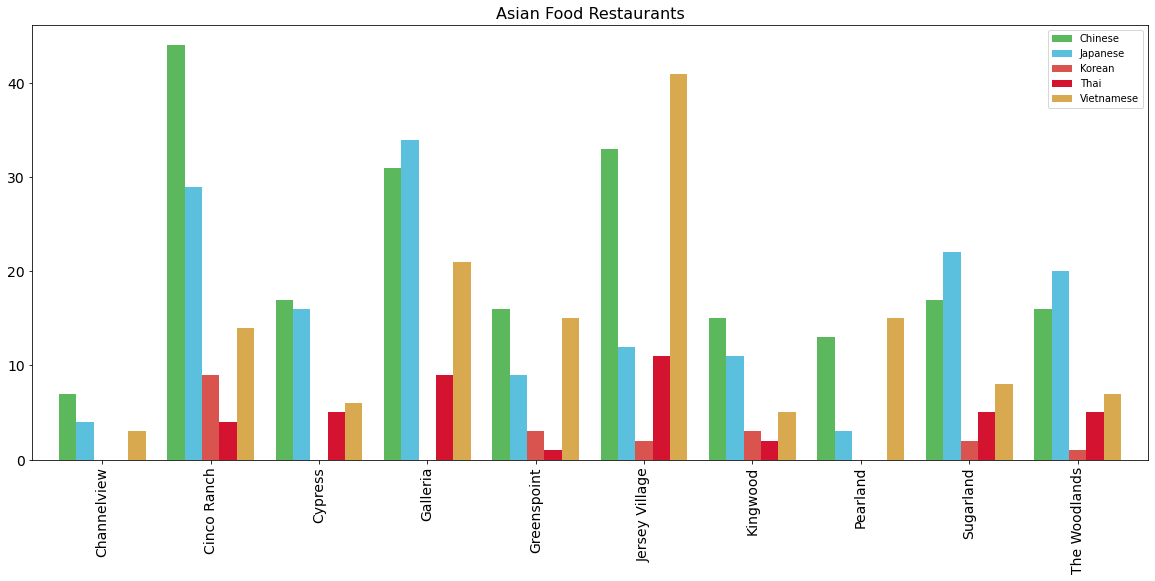

In [8]:
ax = df_counts.plot(kind="bar", figsize=(20,8),
            color=["#5cb85c", "#5bc0de", "#d9534f", "#d3132f", "#d9A94f"],
            width=0.8,
            fontsize=14)
ax.set_title("Asian Food Restaurants", fontsize=16)
ax.set_xticklabels(df_counts['Area'])

<p><strong>Total number of restaurants and CI for each area</strong></p>

In [9]:
asian_rest_short = asian_rest[['Area', 'CI']]
df_count = asian_rest_short.groupby(['Area'], as_index=False).count()
df_sum = asian_rest_short.groupby(['Area'], as_index=False).sum()
totals = df_count
totals['Sum'] = df_sum['CI']
totals.rename(columns={"CI": "Restaurants"}, inplace = True)
totals.rename(columns={"Sum": "CI"}, inplace = True)
totals.sort_values(["Restaurants"], ascending=False, axis=0, inplace=True)
totals

,Area,Restaurants,CI
1,Cinco Ranch,100,176
5,Jersey Village,99,225
3,Galleria,95,177
8,Sugarland,54,92
9,The Woodlands,49,84
2,Cypress,44,78
4,Greenspoint,44,91
6,Kingwood,36,63
7,Pearland,31,74
0,Channelview,14,27


<p><strong>K-Means Clustering</strong></p>

In [10]:
categories = pd.get_dummies(asian_rest[['Category']], prefix="", prefix_sep="")
categories['Area'] = asian_rest['Area']
move_column = [categories.columns[-1]] + list(categories.columns[:-1])
categories = categories[move_column]
categories_grouped = categories.groupby('Area').mean().reset_index()
categories_grouped

,Area,Chinese,Japanese,Korean,Thai,Vietnamese
0,Channelview,0.500000,0.285714,0.000000,0.000000,0.214286
1,Cinco Ranch,0.440000,0.290000,0.090000,0.040000,0.140000
2,Cypress,0.386364,0.363636,0.000000,0.113636,0.136364
3,Galleria,0.326316,0.357895,0.000000,0.094737,0.221053
4,Greenspoint,0.363636,0.204545,0.068182,0.022727,0.340909
5,Jersey Village,0.333333,0.121212,0.020202,0.111111,0.414141
6,Kingwood,0.416667,0.305556,0.083333,0.055556,0.138889
7,Pearland,0.419355,0.096774,0.000000,0.000000,0.483871
8,Sugarland,0.314815,0.407407,0.037037,0.092593,0.148148
9,The Woodlands,0.326531,0.408163,0.020408,0.102041,0.142857


In [11]:
kclusters = 3
clustering = categories_grouped.drop('Area', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

In [12]:
categories_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
categories_grouped.sort_values(["Cluster Labels"], ascending=True, axis=0, inplace=True)
categories_grouped.reset_index(drop=True, inplace=True)
categories_grouped

,Cluster Labels,Area,Chinese,Japanese,Korean,Thai,Vietnamese
0,0,Cypress,0.386364,0.363636,0.000000,0.113636,0.136364
1,0,Galleria,0.326316,0.357895,0.000000,0.094737,0.221053
2,0,Sugarland,0.314815,0.407407,0.037037,0.092593,0.148148
3,0,The Woodlands,0.326531,0.408163,0.020408,0.102041,0.142857
4,1,Greenspoint,0.363636,0.204545,0.068182,0.022727,0.340909
5,1,Jersey Village,0.333333,0.121212,0.020202,0.111111,0.414141
6,1,Pearland,0.419355,0.096774,0.000000,0.000000,0.483871
7,2,Channelview,0.500000,0.285714,0.000000,0.000000,0.214286
8,2,Cinco Ranch,0.440000,0.290000,0.090000,0.040000,0.140000
9,2,Kingwood,0.416667,0.305556,0.083333,0.055556,0.138889


<p><strong>Maps of Kingwood and Cypress showing the location of the restaurants</strong></p>

In [13]:
kingwood = asian_rest.loc[asian_rest['Area']=='Kingwood']
cypress = asian_rest.loc[asian_rest['Area']=='Cypress']

In [14]:
lat_kw = df_areas.loc[df_areas['Area']=='Kingwood', 'Latitude']
lng_kw = df_areas.loc[df_areas['Area']=='Kingwood', 'Longitude']

map_kingwood = folium.Map(location=[lat_kw, lng_kw], zoom_start=12)
for lat, lng, cat in zip(kingwood['RestLat'], 
        kingwood['RestLng'], kingwood['Category']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat_kw, lng_kw],radius=250, color='#577d50', 
                    opacity=0.3, parse_html=False).add_to(map_kingwood)
    if cat=='Vietnamese':
        folium.CircleMarker([lat, lng],radius=2,popup=label, color='#3186cc', 
                            fill=True, fill_color='#3186cc', parse_html=False).add_to(map_kingwood)
    else:
        folium.CircleMarker([lat, lng], radius=2, popup=label, color='#a83250', 
                            fill=True, fill_color='#3186cc', parse_html=False).add_to(map_kingwood) 
map_kingwood

In [15]:
lat_cy = df_areas.loc[df_areas['Area']=='Cypress', 'Latitude']
lng_cy = df_areas.loc[df_areas['Area']=='Cypress', 'Longitude']

map_cypress = folium.Map(location=[lat_cy, lng_cy], zoom_start=12)
for lat, lng, cat in zip(cypress['RestLat'], 
        cypress['RestLng'], cypress['Category']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat_cy, lng_cy],radius=250, color='#577d50', 
                    opacity=0.3, parse_html=False).add_to(map_cypress)
    if cat=='Vietnamese':
        folium.CircleMarker([lat, lng],radius=2,popup=label, color='#3186cc', 
                            fill=True, fill_color='#3186cc', parse_html=False).add_to(map_cypress)
    else:
        folium.CircleMarker([lat, lng], radius=2, popup=label, color='#a83250', 
                            fill=True, fill_color='#3186cc', parse_html=False).add_to(map_cypress) 
map_cypress